# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [ ]:
!ls *snana.dat

She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [197]:
import numpy as np
import astropy as ap

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

# # read in the dat data file using pandas df

sn1 = pd.read_csv("PS1_PS1MD_PSc000098.snana.dat", delim_whitespace=True)
sn2 = pd.read_csv("PS1_PS1MD_PSc000174.snana.dat", delim_whitespace=True)

In [199]:
F1g = np.asarray(sn1[(sn1['FLT'] == 'g')].loc[:,"FLUXCAL"])
F1r = np.asarray(sn1[(sn1['FLT'] == 'r')].loc[:,"FLUXCAL"])
F1i = np.asarray(sn1[(sn1['FLT'] == 'i')].loc[:,"FLUXCAL"])
F1z = np.asarray(sn1[(sn1['FLT'] == 'z')].loc[:,"FLUXCAL"])
t1g = np.asarray(sn1[(sn1['FLT'] == 'g')].loc[:,"MJD"])
t1r = np.asarray(sn1[(sn1['FLT'] == 'r')].loc[:,"MJD"])
t1i = np.asarray(sn1[(sn1['FLT'] == 'i')].loc[:,"MJD"])
t1z = np.asarray(sn1[(sn1['FLT'] == 'z')].loc[:,"MJD"])
Ferr1g = np.asarray(sn1[(sn1['FLT'] == 'g')].loc[:,"FLUXCALERR"])
Ferr1r = np.asarray(sn1[(sn1['FLT'] == 'r')].loc[:,"FLUXCALERR"])
Ferr1i = np.asarray(sn1[(sn1['FLT'] == 'i')].loc[:,"FLUXCALERR"])
Ferr1z = np.asarray(sn1[(sn1['FLT'] == 'z')].loc[:,"FLUXCALERR"])

F2g = np.asarray(sn2[(sn2['FLT'] == 'g')].loc[:,"FLUXCAL"])
F2r = np.asarray(sn2[(sn2['FLT'] == 'r')].loc[:,"FLUXCAL"])
F2i = np.asarray(sn2[(sn2['FLT'] == 'i')].loc[:,"FLUXCAL"])
F2z = np.asarray(sn2[(sn2['FLT'] == 'z')].loc[:,"FLUXCAL"])
t2g = np.asarray(sn2[(sn2['FLT'] == 'g')].loc[:,"MJD"])
t2r = np.asarray(sn2[(sn2['FLT'] == 'r')].loc[:,"MJD"])
t2i = np.asarray(sn2[(sn2['FLT'] == 'i')].loc[:,"MJD"])
t2z = np.asarray(sn2[(sn2['FLT'] == 'z')].loc[:,"MJD"])
Ferr2g = np.asarray(sn2[(sn2['FLT'] == 'g')].loc[:,"FLUXCALERR"])
Ferr2r = np.asarray(sn2[(sn2['FLT'] == 'r')].loc[:,"FLUXCALERR"])
Ferr2i = np.asarray(sn2[(sn2['FLT'] == 'i')].loc[:,"FLUXCALERR"])
Ferr2z = np.asarray(sn2[(sn2['FLT'] == 'z')].loc[:,"FLUXCALERR"])



In [200]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# the likelihood function is the same as we write above, except now as a log
def model_start(theta, t):

    return (theta[0]+theta[3]*(t-theta[1]))/(1+np.exp(-(t-theta[1])/theta[2]))
    
def model_end(theta, t):
    t1=theta[4]+theta[1]
    return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))

def model(theta, t):
    fluxes = np.piecewise(t, [t < theta[4], t >= theta[4]], [lambda t: model_start(theta,t),lambda t: model_end(theta,t)])
    return fluxes

def log_likelihood(theta, t, f, err):
    
    # this is the residual
    dy = f - np.nan_to_num(model(theta,t))
    
    # you should write two log-likelihood terms to implement the sum in the above formula
    # as logL1 and logL2
    logL = dy**2/(2*err**2)
    
    # we have the sum of two PDFs that we took the log of
    # to do this when we write those PDFs itself as logs, we can use np.logaddexp
    return -.5*np.sum(logL)

def log_prior(theta,Fmax,tmin,tmax):
#     if 0<theta[0] and theta[0]<100*Fmax and tmin-50<theta[1] and theta[1]<tmax+300 and .01<theta[2] and theta[2]<50 and -Fmax/150<theta[3] and theta[3]<0 and 1<theta[5] and theta[5]<300:
#         probs = 0 
#     else:
#         probs = -np.inf
    
#     gauss_prob = np.log(((2/3)*(1/(5*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-5)/5)**2)) + 
#                  (1/3)*1/(30*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-60)/30)**2)))
#     return (probs+gauss_prob)
    if 0<theta[0] and theta[0]<10*Fmax:
        prob1 = np.log(1/(10*Fmax))
    else:
        prob1 = -np.inf
        
    if tmin-50<theta[1] and theta[1]<tmax+100:
        prob2 = np.log(1/((tmax+100)-(tmin-50)))
    else:
        prob2 = -np.inf
        
    if .01<theta[2] and theta[2]<50:
        prob3 = np.log(1/(50-.01))
    else:
        prob3 = -np.inf
        
    if -Fmax/150<theta[3] and theta[3]<0:
        prob4 = np.log(1/(Fmax/150))
    else:
        prob4 = -np.inf
        
    prob5 = np.log(((2/3)*(1/(5*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-5)/5)**2)) + 
            (1/3)*1/(30*np.sqrt(2*np.pi))*np.exp(-.5*((theta[4]-60)/30)**2)))

    if 1<theta[5] and theta[5]<300:
        prob6 = np.log(1/(300-1))
    else:
        prob6 = -np.inf
    return prob1+prob2+prob3+prob4+prob5+prob6

def log_posterior(theta, t, f, err,Fmax, tmin, tmax):
    # posterior is product of likelihood and prior (or sum of log likelihoods)
#     print((log_prior(theta, Fmax,tmin,tmax)), (log_likelihood(theta, t, f, err)),theta)
    if not np.isfinite(log_likelihood(theta, t, f, err)):
        return -np.inf
    return np.nan_to_num(log_prior(theta, Fmax,tmin,tmax) + log_likelihood(theta, t, f, err))


In [201]:
def initialize_params(Fmax, tmin, tmax,nwalkers,ndim):
    # set theta as priors stated in Table 1
    np.random.seed(10)

    starting_guesses = np.zeros((nwalkers, ndim))
    starting_guesses[:, 0] = np.random.uniform(0, 10*Fmax, nwalkers)
    starting_guesses[:, 1] = np.random.uniform(tmin-50, tmax+100, nwalkers)
    starting_guesses[:, 2] = np.random.uniform(.01, 50, nwalkers)
    starting_guesses[:, 3] = np.random.uniform(-Fmax/150, 0, nwalkers)
    starting_guesses[:, 4] = (2/3)*np.random.normal(5, 5, nwalkers)+(1/3)*np.random.normal(60, 30, nwalkers)
    starting_guesses[:, 5] = np.random.uniform(1, 300, nwalkers)
    return starting_guesses

In [214]:
#theta array contains: A, t_0, t_rise, beta, gamma,t_fall
# Note that this step will take a few minutes to run!

ndim = 6 # number of parameters in the model
nwalkers = 20  # number of MCMC walkers

# Burnin
# initially the Markov chain is clearly not in it's stationary state at all 
# Conservatively, we might remove the first ~5000 steps based on this. 
# This period is called the **burn in**.

nburn = 8000  # "burn-in" period to let chains stabilize
nsteps = 30000  # number of MCMC steps to take

Fmax = max(F2g)
tmin = min(t2g)
tmax = max(t2g)
starting_guess = initialize_params(Fmax, tmin, tmax,nwalkers,ndim)



In [215]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t2g, F2g, Ferr2g,Fmax,tmin,tmax])
_ =  sampler.run_mcmc(starting_guess, nsteps, rstate0=np.random.get_state())

/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_56301/563796426.py:9: RuntimeWarning: overflow encountered in exp
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_56301/563796426.py:22: RuntimeWarning: overflow encountered in square
  logL = dy**2/(2*err**2)
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_56301/563796426.py:9: RuntimeWarning: overflow encountered in multiply
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))
/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_56301/563796426.py:9: RuntimeWarning: invalid value encountered in divide
  return (((theta[0]+theta[3]*(t1-theta[1])))*np.exp(-(t-t1)/theta[5]))/(1+np.exp(-(t-theta[1])/theta[2]))


In [216]:
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

In [217]:
sample.shape


(240000, 6)

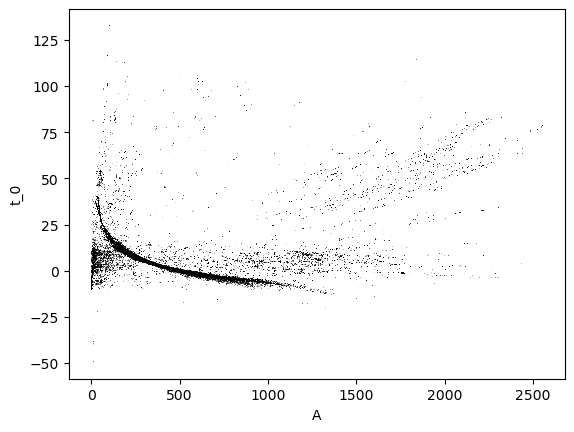

In [218]:
plt.plot(sample[:, 0], sample[:, 4], ',k', alpha=0.1)
plt.xlabel('A')
plt.ylabel('t_0');

In [219]:
theta = np.median(sample,0)

In [220]:
print(theta)
print('A, t0, trise,beta,t1,tfall')

[ 3.07956741e+02  5.52141641e+04  3.85081202e+00 -7.43383672e-01
  3.87796490e+00  1.10961208e+01]
A, t0, trise,beta,t1,tfall


/var/folders/0m/nl5m64s17m35qg4xbhqzbtdw0000gn/T/ipykernel_56301/1999378859.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


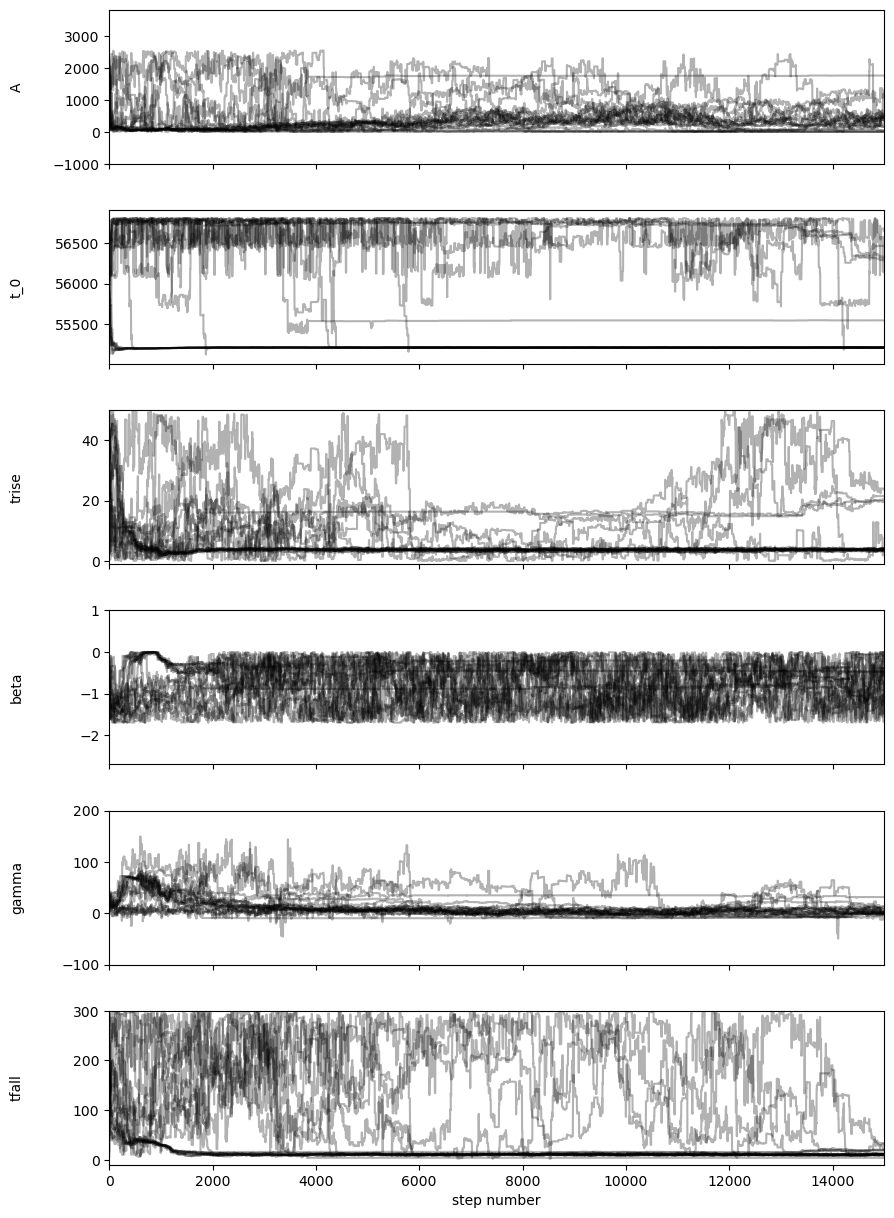

In [221]:
fig,axes=plt.subplots(6,1,figsize=(10,15),sharex=True, gridspec_kw={'hspace':0.3})
samples = sampler.get_chain()
labels = ['A','t_0','trise','beta','gamma','tfall']
yrange=[(-1000,15*Fmax),(tmin-50-100,tmax+100+100),(-1.01,50),(-1-Fmax/150,0+1),(-100,200),(-10,300)]
for i in range(6):
    ax=axes[i]
    ax.plot(samples[:,:,i],'k',alpha=.3)
    ax.set(xlim=(0,30000),ylim=yrange[i],ylabel=labels[i])
    ax.yaxis.set_label_coords(-.11,.5)
axes[-1].set_xlabel('step number')
fig.tight_layout()

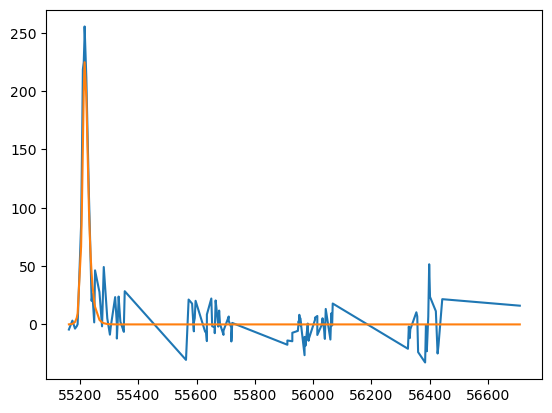

In [222]:
plt.plot(t2g,F2g)
plt.plot(t2g,model(theta,t2g))

In [211]:
flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
print(flat_samples.shape)


(17320, 6)


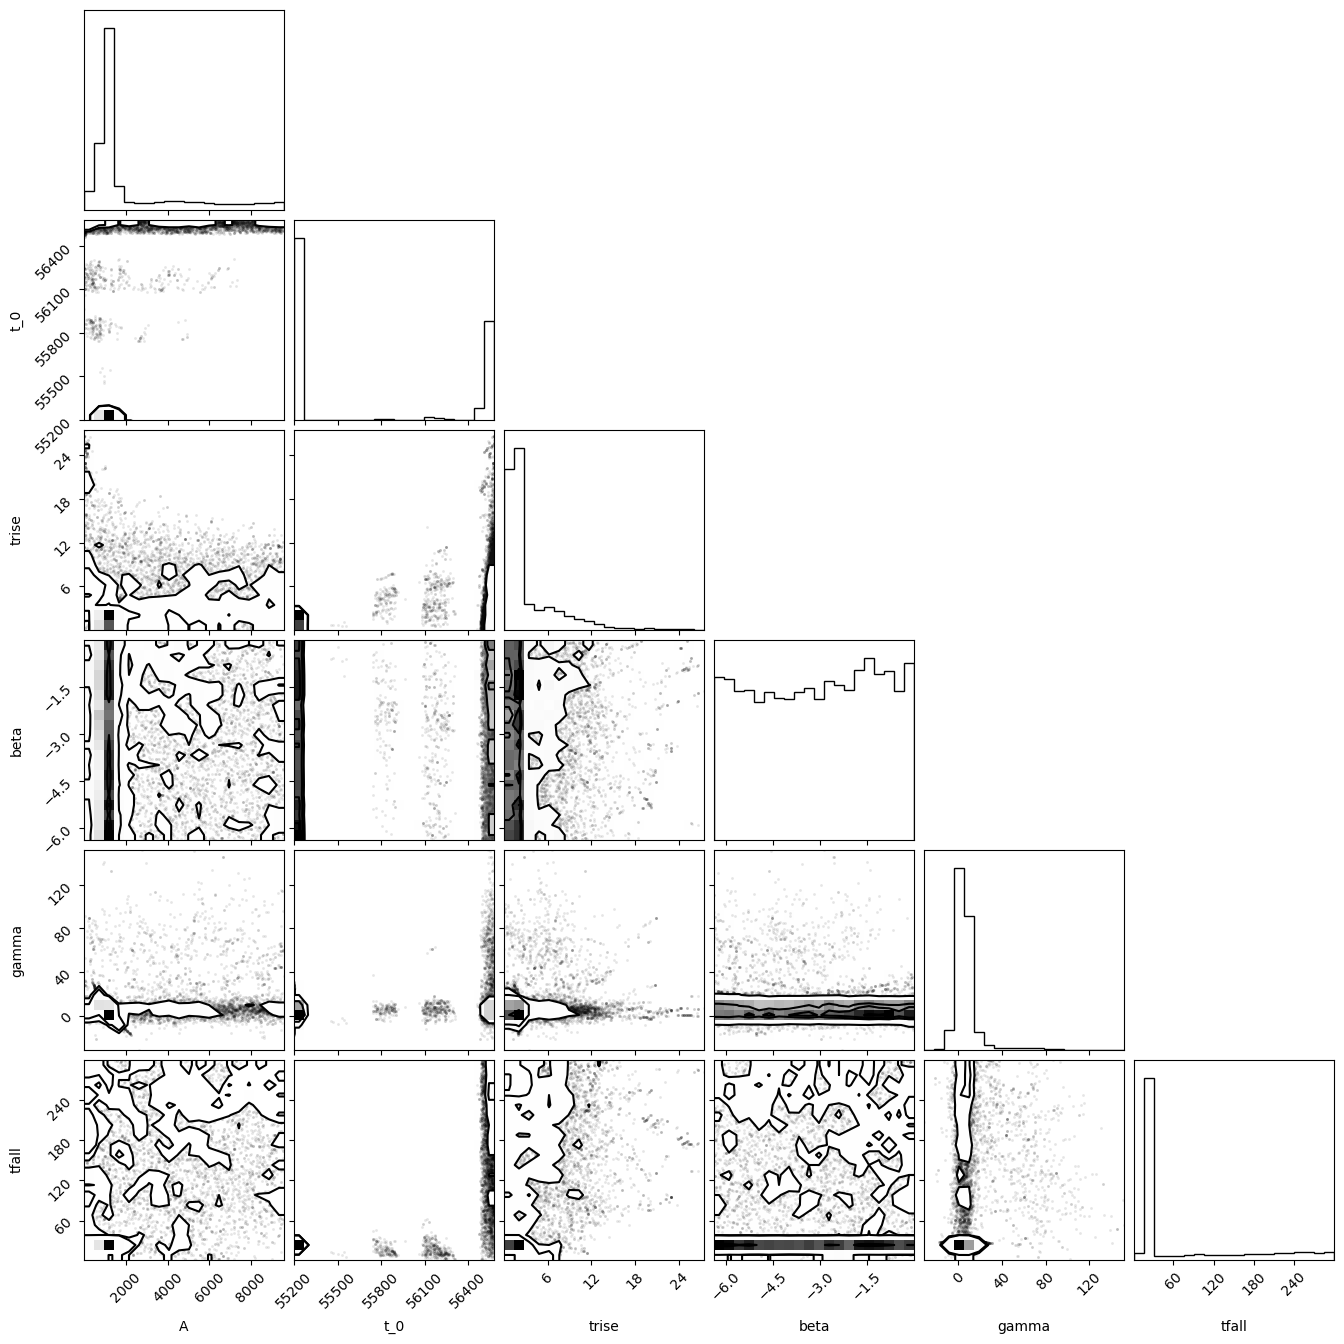

In [212]:
import corner

fig = corner.corner(
    flat_samples, labels=labels);